In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets,decomposition,manifold

sonar = pd.read_csv('sonar.all-data',header=None,sep=',')
sonar1 = sonar.iloc[0:208,0:60]
sonar2 = np.mat(sonar1)


pc = 0.05 # pc为变异的概率
t = 150   #遗传算法迭代的次数
n = 60    #种群的个体数,要求大于20以保证具有随机性
# d = 30  # d为要选择的特征个数

In [2]:
#遗传算法
def GA(d):
    population = np.zeros((n,60))     # 初始化种群
    for i in range(n):                # 定义种群的个体数为 n
        a = np.zeros(60-d)
        b = np.ones(d)                # 将选择的d维特征定义为个体c中的1
        c = np.append(a,b)
        c = (np.random.permutation(c.T)).T    # 随机生成一个d维的个体
        population[i] = c             # 初代的种群为 population，共有n个个体
        
    #遗传算法的迭代次数为t
    fitness_change = np.zeros(t)
    for i in range(t):
        fitness = np.zeros(n)             # fitness为每一个个体的适应度值
        for j in range(n):
            fitness[j] = Jd(population[j])          # 计算每一个体的适应度值   
        population = selection(population,fitness)  # 通过概率选择产生新一代的种群
        population = crossover(population)          # 通过交叉产生新的个体
        population = mutation(population)           # 通过变异产生新个体
        fitness_change[i] = max(fitness)      #找出每一代的适应度最大的染色体的适应度值
        
    # 随着迭代的进行，每个个体的适应度值应该会不断增加，所以总的适应度值fitness求平均应该会变大
    best_fitness = max(fitness)
    best_people = population[fitness.argmax()]
    
    return best_people,best_fitness,fitness_change,population
 

In [ ]:
#轮盘赌选择
def selection(population,fitness):
    fitness_sum = np.zeros(n)
    for i in range(n):
        if i==0:
            fitness_sum[i] = fitness[i]
        else:
            fitness_sum[i] = fitness[i] + fitness_sum[i-1]
    for i in range(n):
        fitness_sum[i] = fitness_sum[i] / sum(fitness)
    
    #选择新的种群
    population_new = np.zeros((n,60))
    for i in range(n):
        rand = np.random.uniform(0,1)
        for j in range(n):
            if j==0:
                if rand<=fitness_sum[j]:
                    population_new[i] = population[j]
            else:
                if fitness_sum[j-1]<rand and rand<=fitness_sum[j]:
                    population_new[i] = population[j]
    return population_new
    

In [4]:
#交叉操作
def crossover(population):
    father = population[0:10,:]
    mother = population[10:,:]
    np.random.shuffle(father)       # 将父代个体按行打乱以随机配对
    np.random.shuffle(mother)
    for i in range(10):
        father_1 = father[i]
        mother_1 = mother[i]
        one_zero = []
        zero_one = []
        for j in range(60):
            if father_1[j]==1 and mother_1[j]==0:
                one_zero.append(j)
            if father_1[j]==0 and mother_1[j]==1:
                zero_one.append(j)
        length1 = len(one_zero)
        length2 = len(zero_one)
        length = max(length1,length2)
        half_length = int(length/2)        #half_length为交叉的位数 
        for k in range(half_length):       #进行交叉操作
            p = one_zero[k]
            q = zero_one[k]
            father_1[p]=0
            mother_1[p]=1
            father_1[q]=1
            mother_1[q]=0
        father[i] = father_1               #将交叉后的个体替换原来的个体
        mother[i] = mother_1
    population = np.append(father,mother,axis=0)
    return population
  

In [5]:
#变异操作
def mutation(population):
    for i in range(n):
        c = np.random.uniform(0,1)
        if c<=pc:
            mutation_s = population[i]
            zero = []                           # zero存的是变异个体中第几个数为0
            one = []                            # one存的是变异个体中第几个数为1
            for j in range(60):
                if mutation_s[j]==0:
                    zero.append(j)
                else:
                    one.append(j)
                    
            if (len(zero)!=0) and (len(one)!=0):
                a = np.random.randint(0,len(zero))    # e是随机选择由0变为1的位置
                b = np.random.randint(0,len(one))     # f是随机选择由1变为0的位置
                e = zero[a]
                f = one[b]
                mutation_s[e] = 1
                mutation_s[f] = 0
                population[i] = mutation_s
            
    return population


In [6]:
#个体适应度函数 Jd(x)，x是d维特征向量(1*60维的行向量,1表示选择该特征)
def Jd(x):
    #从特征向量x中提取出相应的特征
    Feature = np.zeros(d)        #数组Feature用来存 x选择的是哪d个特征
    k = 0
    for i in range(60):
        if x[i] == 1:
            Feature[k] = i
            k+=1
    
    #将30个特征从sonar2数据集中取出重组成一个208*d的矩阵sonar3
    sonar3 = np.zeros((208,1))
    for i in range(d):
        p = Feature[i]
        p = p.astype(int)
        q = sonar2[:,p]
        q = q.reshape(208,1)
        sonar3 = np.append(sonar3,q,axis=1)
    sonar3 = np.delete(sonar3,0,axis=1)
    
    #求类间离散度矩阵Sb
    sonar3_1 = sonar3[0:97,:]        #sonar数据集分为两类
    sonar3_2 = sonar3[97:208,:]
    m = np.mean(sonar3,axis=0)       #总体均值向量
    m1 = np.mean(sonar3_1,axis=0)    #第一类的均值向量
    m2 = np.mean(sonar3_2,axis=0)    #第二类的均值向量
    m = m.reshape(d,1)               #将均值向量转换为列向量以便于计算
    m1 = m1.reshape(d,1)
    m2 = m2.reshape(d,1)
    Sb = ((m1 - m).dot((m1 - m).T)*(97/208) + (m2 - m).dot((m2 - m).T)*(111/208)) #除以类别个数
  
    #求类内离散度矩阵Sw
    S1 = np.zeros((d,d))
    S2 = np.zeros((d,d))
    for i in range(97):
        S1 += (sonar3_1[i].reshape(d,1)-m1).dot((sonar3_1[i].reshape(d,1)-m1).T)
    S1 = S1/97
    for i in range(111):
        S2 += (sonar3_2[i].reshape(d,1)-m2).dot((sonar3_2[i].reshape(d,1)-m2).T)
    S2 = S2/111
    
    Sw = (S1*(97/208) + S2*(111/208))
   # Sw = (S1 + S2) / 2
    #计算个体适应度函数 Jd(x)
    J1 = np.trace(Sb)
    J2 = np.trace(Sw)
    Jd = J1/J2
    
    return Jd


在取30维的时候，通过遗传算法得出的最优适应度值为：0.061494
[0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.]


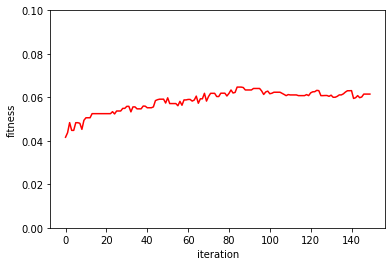

In [7]:
#GA Main函数
best_d = np.zeros(59)          # judge存的是每一个维数的最优适应度

for d in range(30,31):            # d为从60个特征中选择的特征维数
    best_people,best_fitness,fitness_change,best_population = GA(d)     # fitness_change是遗传算法在迭代过程中适应度变化
    best_d[d-1] = best_fitness     # best是每一维数迭代到最后的最优的适应度，用于比较
    print("在取%d维的时候，通过遗传算法得出的最优适应度值为：%.6f"%(d,best_fitness))

'''
若要看遗传算法的收敛情况，则看在d=30的情况下的fitness_change就可以
'''
'''
#EXPERIMENT1:探究特征维数对最优适应值的影响
x = np.arange(0,59,1)
plt.xlabel('dimension')
plt.ylabel('fitness')
plt.ylim((0,0.3))            # y坐标的范围
plt.plot(x,best_d,'r')
plt.savefig("Sonar_best_d.jpg",dpi=2000)
'''

'''
#EXPERIMENT2:查看单特征维度下遗传算法迭代过程中种群适应值变化
'''
x = np.arange(0,t,1)
plt.xlabel('iteration')
plt.ylabel('fitness')
plt.ylim((0,0.1))            # y坐标的范围
plt.plot(x,fitness_change,'r')
plt.savefig("Sonar_evolution_fitness.jpg",dpi=2000)
print(best_people)

In [8]:
def Fisher(X1,X2,n,c):
    
    # 计算三类样本的类均值向量
    m1=(np.mean(X1,axis = 0))
    m2=(np.mean(X2,axis = 0))
    m1 = m1.reshape(n,1)   # 将行向量转换为列向量以便于计算
    m2 = m2.reshape(n,1)

    #计算类内离散度矩阵
    S1 = np.zeros((n,n))              # m1 = within_class_scatter_matrix1
    S2 = np.zeros((n,n))              # m2 = within_class_scatter_matrix2
    if c == 0:                          # 第一种情况
        for i in range(0,96):
            S1 += (X1[i].reshape(n,1)-m1).dot((X1[i].reshape(n,1)-m1).T)
        for i in range(0,111):
            S2 += (X2[i].reshape(n,1)-m2).dot((X2[i].reshape(n,1)-m2).T)
    if c == 1:
        for i in range(0,97):
            S1 += (X1[i].reshape(n,1)-m1).dot((X1[i].reshape(n,1)-m1).T)
        for i in range(0,110):
            S2 += (X2[i].reshape(n,1)-m2).dot((X2[i].reshape(n,1)-m2).T)
    #计算总类内离散度矩阵S_w
    S_w = S1 + S2

    #计算最优投影方向 W
    W = np.linalg.inv(S_w).dot(m1 - m2)
    #在投影后的一维空间求两类的均值
    m_1 = (W.T).dot(m1)
    m_2 = (W.T).dot(m2)
    
    #计算分类阈值 W0(为一个列向量)
    W0 = -0.5*(m_1 + m_2)
    
    return W,W0


In [9]:
def Classify(X,W,W0):
    y = (W.T).dot(X) + W0
    return y


In [19]:
#导入sonar.all-data数据集
sonar = pd.read_csv('sonar.all-data',header=None,sep=',')
sonar1 = sonar.iloc[0:208,0:60]
sonar2 = np.mat(sonar1)

#根据GA中的特征维度选择进行特征筛选
best_people = best_people.astype(int)
to_delete = []
for i in range(60):
    if best_people[i] == 0 :
        to_delete.append(i)
sonar2 = np.delete(sonar2, to_delete, axis=1)

n = 30    #n是当前的维数
Accuracy = np.zeros(30)
accuracy_ = np.zeros(10)

In [20]:
for t in range(10):             # 每一维都求十次平均值
    sonar_random = (np.random.permutation(sonar2.T)).T    # 对原sonar数据进行每列打乱   

    P1 = sonar_random[0:97,0:n]
    P2 = sonar_random[97:208,0:n]

    count = 0
    #留一法验证准确性
    for i in range(208):
        if i <= 96:
            test = P1[i]
            test = test.reshape(n,1)
            train = np.delete(P1,i,axis=0)       # 训练样本是一个列数为t的矩阵
            W,W0 = Fisher(train,P2,n,0)
            if (Classify(test,W,W0)) >= 0:
                count += 1
        else:
            test = P2[i-97]
            test = test.reshape(n,1)
            train = np.delete(P2,i-97,axis=0)
            W,W0 = Fisher(P1,train,n,1)
            if (Classify(test,W,W0)) < 0:
                count += 1
    accuracy_[t] = count/208
for k in range(10):
    Accuracy[n-1] += accuracy_[k]
Accuracy[n-1] = Accuracy[n-1]/10
GA_LDA_accuracy = Accuracy[n-1]
print("当数据为%d维时，Accuracy:%.3f"%(n,Accuracy[n-1]))

当数据为30维时，Accuracy:0.760


In [26]:
Accuracy = np.zeros(60)
accuracy_ = np.zeros(10)
sonar2 = np.mat(sonar1)
n = 60

for n in range(1,61):               # n是当前的维数
    for t in range(10):             # 每一维都求十次平均值
        sonar_random = (np.random.permutation(sonar2.T)).T    # 对原sonar数据进行每列打乱   

        P1 = sonar_random[0:97,0:n]
        P2 = sonar_random[97:208,0:n]
        
        count = 0
        #留一法验证准确性
        for i in range(208):
            if i <= 96:
                test = P1[i]
                test = test.reshape(n,1)
                train = np.delete(P1,i,axis=0)       # 训练样本是一个列数为t的矩阵
                W,W0 = Fisher(train,P2,n,0)
                if (Classify(test,W,W0)) >= 0:
                    count += 1
            else:
                test = P2[i-97]
                test = test.reshape(n,1)
                train = np.delete(P2,i-97,axis=0)
                W,W0 = Fisher(P1,train,n,1)
                if (Classify(test,W,W0)) < 0:
                    count += 1
        accuracy_[t] = count/208
    for k in range(10):
        Accuracy[n-1] += accuracy_[k]
    Accuracy[n-1] = Accuracy[n-1]/10
    print("当数据为%d维时，Accuracy:%.3f"%(n,Accuracy[n-1]))



当数据为1维时，Accuracy:0.561
当数据为2维时，Accuracy:0.587
当数据为3维时，Accuracy:0.639
当数据为4维时，Accuracy:0.629
当数据为5维时，Accuracy:0.650
当数据为6维时，Accuracy:0.678
当数据为7维时，Accuracy:0.683
当数据为8维时，Accuracy:0.687
当数据为9维时，Accuracy:0.703
当数据为10维时，Accuracy:0.723
当数据为11维时，Accuracy:0.693
当数据为12维时，Accuracy:0.724
当数据为13维时，Accuracy:0.716
当数据为14维时，Accuracy:0.715
当数据为15维时，Accuracy:0.719
当数据为16维时，Accuracy:0.725
当数据为17维时，Accuracy:0.726
当数据为18维时，Accuracy:0.725
当数据为19维时，Accuracy:0.730
当数据为20维时，Accuracy:0.735
当数据为21维时，Accuracy:0.730
当数据为22维时，Accuracy:0.736
当数据为23维时，Accuracy:0.726
当数据为24维时，Accuracy:0.738
当数据为25维时，Accuracy:0.733
当数据为26维时，Accuracy:0.733
当数据为27维时，Accuracy:0.742
当数据为28维时，Accuracy:0.742
当数据为29维时，Accuracy:0.740
当数据为30维时，Accuracy:0.732
当数据为31维时，Accuracy:0.740
当数据为32维时，Accuracy:0.750
当数据为33维时，Accuracy:0.738
当数据为34维时，Accuracy:0.750
当数据为35维时，Accuracy:0.744
当数据为36维时，Accuracy:0.742
当数据为37维时，Accuracy:0.738
当数据为38维时，Accuracy:0.732
当数据为39维时，Accuracy:0.725
当数据为40维时，Accuracy:0.745
当数据为41维时，Accuracy:0.743
当数据为42维时，Accuracy:0.735
当

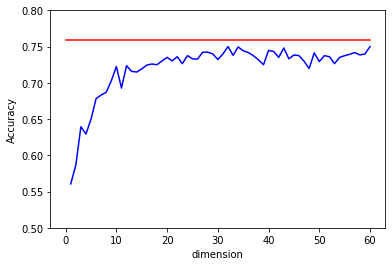

In [31]:
# 画相关的图
import matplotlib.pyplot as plt

x = np.arange(1,61,1)
plt.xlabel('dimension')
plt.ylabel('Accuracy')
plt.ylim((0.5,0.8))            # y坐标的范围
#画图
plt.plot(x,Accuracy,'b')
plt.plot([0,60],[GA_LDA_accuracy,GA_LDA_accuracy],color='red',)
plt.show()
